In [115]:
from os import listdir
import gzip
import numpy as np
from scipy import sparse

# load genotypes
chrom = 22
gen_files = sorted([f for f in listdir('split_gen') if ('chr.%d' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('split_gen/%s' % gen_file) for gen_file in gen_files])
m, n = whole_chrom.shape
print(m, n)

# pull indices of snps
variant_file = 'split_gen/chr.%d.gen.variants.txt.gz' % chrom
snp_indices = []
snp_positions = []
with gzip.open(variant_file, 'rt') as f:
    for i, line in enumerate(f):
        pieces = line.strip().split('\t')
        if len(pieces[3]) == 1 and len(pieces[4]) == 1 and pieces[3] != '.' and pieces[4] != '.':
            snp_indices.append(i)
            snp_positions.append(int(pieces[1]))
snp_positions = np.asarray(snp_positions)

whole_chrom = whole_chrom[:, snp_indices]
m, n = whole_chrom.shape
family_to_state = dict([(k, v[0][0][4:]) for k, v in family_to_states.items()])
#segment = whole_chrom[:, (snp_positions>=start) & (snp_positions <= end)].A
#m, n = segment.shape
print(m, n)

4610 1096535
4610 1004649


In [116]:
is_neg = (segment == -1)
x, y = np.where(is_neg[:, :-4] & is_neg[:, 1:-3] & is_neg[:, 2:-2] & is_neg[:, 3:-1] & is_neg[:, 4:])
segment[x, y+2] = -2
print('Changed %0.2f of missing to deleted' % (x.shape[0]/np.sum(is_neg)))

Changed 0.00 of missing to deleted


In [186]:
from collections import defaultdict

# pull inheritance pattern in region of interest
start, end = 24340000, 24400000

# 0 = no deletion, 1 = single deletion, 2 = double deletion
regions = np.zeros((m, n), dtype=int)

family_to_individuals = dict()
individual_to_index = dict()
family_to_states = defaultdict(list)
for j in range(3, 7):
    with open('phased/chr.22.familysize.%d.families.txt' % j, 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            family_to_individuals[family_key] = pieces[1:(1+j)]
            for ind_id, index in zip(pieces[1:(1+j)], [int(x) for x in pieces[(1+j):]]):
                individual_to_index[ind_id] = index
                
    # load deletions
    with open('phased/chr.22.familysize.%d.phased.txt' % j, 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            if family_key in family_to_individuals:
                individuals = family_to_individuals[family_key]
                inheritance_state = [int(x) for x in pieces[2:(2+(j*2))]]
                start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(2+(j*2)):(6+(j*2))]]
                length = end_pos - start_pos + 1

                regions[individual_to_index[individuals[0]], start_index:end_index] = sum(inheritance_state[0:2])
                regions[individual_to_index[individuals[1]], start_index:end_index] = sum(inheritance_state[2:4])
                for index, child in enumerate(individuals[2:]):
                    mat, pat = inheritance_state[(4+(2*index)):(6+(2*index))]
                    regions[individual_to_index[child], start_index:end_index] = inheritance_state[mat] + inheritance_state[2+pat]

                if start_pos >= start and start_pos <= end:
                    family_to_states[family_key].append((inheritance_state, start_pos, end_pos, min(end_pos, end)-max(start_pos, start)))
                elif end_pos >= start and end_pos <= end:
                    family_to_states[family_key].append((inheritance_state, start_pos, end_pos, min(end_pos, end)-max(start_pos, start)))
                elif start_pos <= start and end_pos >= end:
                    family_to_states[family_key].append((inheritance_state, start_pos, end_pos, min(end_pos, end)-max(start_pos, start)))
                elif start_pos >= start and end_pos <= end:
                    family_to_states[family_key].append((inheritance_state, start_pos, end_pos, min(end_pos, end)-max(start_pos, start)))
                
index_to_individual = dict([(v, k) for k, v in individual_to_index.items()])
print('Families', len(family_to_individuals))
print('Missing States', family_to_individuals.keys() - family_to_states.keys())


Families 867
Missing States set()


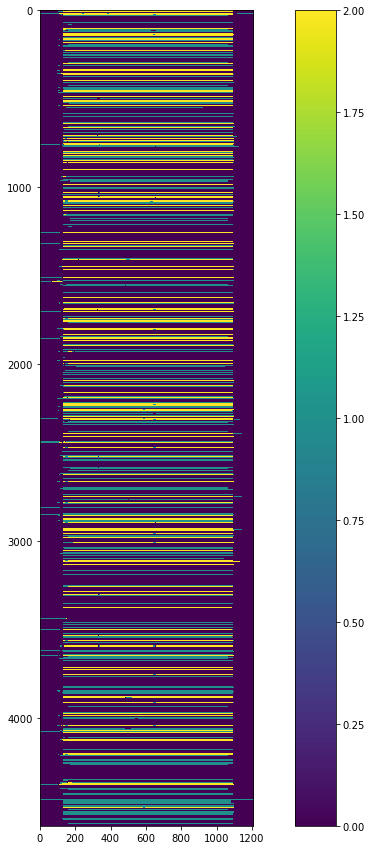

In [187]:
plt.figure(figsize=(15, 15))
plt.imshow(regions[:, (snp_positions>=start) & (snp_positions <= end)])
plt.colorbar()
plt.show()

In [169]:
family_to_state = dict()
for family, states in family_to_states.items():
    for i in len(states[0][0]):
        pass
print('Confusion')
print('\t\tMom\tDad\tChildren')
print('Double del\t%d\t%d' % (len([x for x in family_to_state.values() if sum(x[:2])==2]),
                                   len([x for x in family_to_state.values() if sum(x[2:4])==2])))
print('Single del\t%d\t%d' % (len([x for x in family_to_state.values() if sum(x[:2])==1]),
                                   len([x for x in family_to_state.values() if sum(x[2:4])==1])))
print('No del\t\t%d\t%d' % (len([x for x in family_to_state.values() if sum(x[:2])==0]),
                                   len([x for x in family_to_state.values() if sum(x[2:4])==0])))

defaultdict(<class 'list'>, {'AU0080.AU008001.AU008002': [([0, 0, 0, 0, 0, 0], 24308358, 25394741, 60000)], 'AU0197.AU019701.AU019702': [([0, 0, 0, 0, 0, 0], 24199314, 24342791, 2791), ([0, 1, 0, 0, 0, 0], 24342997, 24343045, 48), ([1, 1, 0, 0, 0, 0], 24343250, 24343283, 33), ([1, 1, 1, 0, 0, 0], 24343454, 24397304, 53850), ([1, 0, 1, 0, 0, 0], 24397392, 24398334, 942), ([0, 0, 1, 0, 0, 0], 24398343, 24398586, 243), ([0, 0, 0, 0, 0, 0], 24398868, 25395992, 1132)], 'AU1056.AU1056202.AU1056203': [([0, 0, 0, 0, 0, 0], 24198284, 24342997, 2997), ([0, 0, 1, 0, 0, 0], 24343454, 24343454, 0), ([1, 0, 1, 0, 0, 0], 24343493, 24397298, 53805), ([0, 0, 1, 0, 0, 0], 24397301, 24397301, 0), ([0, 0, 0, 0, 0, 0], 24397304, 25407856, 2696)], 'AU1270.AU1270202.AU1270201': [([0, 0, 0, 0, 0, 0], 24333798, 25416292, 60000)], 'AU1290.AU1290202.AU1290201': [([0, 0, 0, 0, 0, 0], 24311297, 24342860, 2860), ([0, 0, 1, 0, 0, 0], 24342997, 24342997, 0), ([0, 0, 1, 1, 0, 0], 24343454, 24397298, 53844), ([0, 0, 0,

TypeError: 'int' object is not iterable

In [156]:
segment = whole_chrom[:, (snp_positions>=start) & (snp_positions <= end)].A + 3

In [170]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
fam_indices = sum([[individual_to_index[y] for y in x] for x in family_to_individuals.values()], [])
region_segment = regions[:, (snp_positions>=start) & (snp_positions <= end)]

print(np.unique(segment[fam_indices, :] * (region_segment[fam_indices, :] == 0), return_counts=True))
print(np.unique(segment[fam_indices, :] * (region_segment[fam_indices, :] == 1), return_counts=True))
print(np.unique(segment[fam_indices, :] * (region_segment[fam_indices, :] == 2), return_counts=True))

(array([0, 2, 3, 4, 5], dtype=int8), array([150698,   1392, 247832,   5605,   8131]))
(array([0, 2, 3, 4, 5], dtype=int8), array([323351,    650,  85616,    371,   3670]))
(array([0, 2, 3, 4, 5], dtype=int8), array([353267,  58350,   1893,      5,    143]))


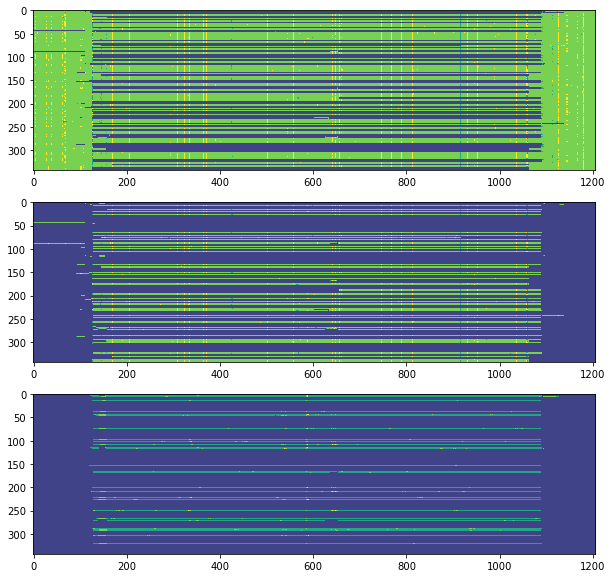

In [171]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.imshow(segment[fam_indices, :] * (region_segment[fam_indices, :] == 0), vmin=-1, vmax=4)
plt.subplot(3, 1, 2)
plt.imshow(segment[fam_indices, :] * (region_segment[fam_indices, :] == 1), vmin=-1, vmax=4)
plt.subplot(3, 1, 3)
plt.imshow(segment[fam_indices, :] * (region_segment[fam_indices, :] == 2), vmin=-1, vmax=4)
plt.show()

['AU019701', 'AU019702', 'AU019703'] , ['AU019701', 'AU019703']
['AU1056202', 'AU1056203', 'AU1056304'] , ['AU1056304']
['AU1290202', 'AU1290201', 'AU1290303'] , ['AU1290201']
['AU1511202', 'AU1511201', 'AU1511303'] , ['AU1511202', 'AU1511303']
['AU1245202', 'AU1245203', 'AU1245302'] , ['AU1245203']
['AU1553202', 'AU1553203', 'AU1553301'] , ['AU1553203']
['AU1903202', 'AU1903201', 'AU1903304'] , ['AU1903202', 'AU1903201', 'AU1903304']
['AU2488202', 'AU2488203', 'AU2488302'] , ['AU2488203', 'AU2488302']
['AU3295202', 'AU3295201', 'AU3295303'] , ['AU3295201', 'AU3295303']


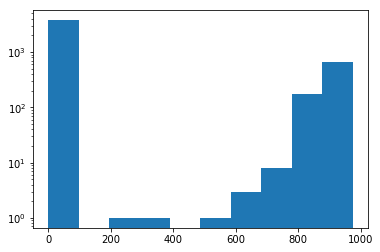

In [85]:
index_to_deleted = dict([(i, np.sum(segment[i, :]==-2)) for i in range(m)])
print('\n'.join([str(v)+' , '+str([x for x in v if index_to_deleted[individual_to_index[x]]> 500]) for f, v in family_to_individuals.items() if len([x for x in v if index_to_deleted[individual_to_index[x]]> 500])]))
plt.hist(np.sum(segment==-2, axis=1), log=True)
plt.show()